In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## 1. Importing Libraries

In [2]:
import tensorflow as tf

from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
import pandas as pd

In [3]:
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

: /physical_device:CPU:0


In [4]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


## 2. Gathering Data

In [5]:
# defining paths of train, validation and test data
train_path = "../input/wildfire-prediction-dataset/train"
valid_path = "../input/wildfire-prediction-dataset/valid"
test_path = "../input/wildfire-prediction-dataset/test"

## 3. Analysing the Data

In [16]:
def print_df(df):
    print(f'Number of pictures: {df.shape[0]}\n')
    print(f'Number of different labels: {len(df.Label.unique())}\n')
    print(f'Labels: {df.Label.unique()}')

    # The DataFrame with the filepaths in one column and the labels in the other one
    print(df.head(5))

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures"""

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

In [27]:
from pathlib import Path

# Assuming train_path, test_path, and valid_path are string variables containing directory paths

# Convert strings to Path objects
train_path = Path(train_path)
test_path = Path(test_path)
valid_path = Path(valid_path)

# Use Path objects to list JPEG files
df_train = proc_img(list(train_path.glob('**/*.jpg')))
df_test = proc_img(list(test_path.glob('**/*.jpg')))
df_valid = proc_img(list(valid_path.glob('**/*.jpg')))

In [28]:
print_df(df_train)

Number of pictures: 30250

Number of different labels: 2

Labels: ['wildfire' 'nowildfire']
                                            Filepath       Label
0  ../input/wildfire-prediction-dataset/train/wil...    wildfire
1  ../input/wildfire-prediction-dataset/train/now...  nowildfire
2  ../input/wildfire-prediction-dataset/train/wil...    wildfire
3  ../input/wildfire-prediction-dataset/train/wil...    wildfire
4  ../input/wildfire-prediction-dataset/train/now...  nowildfire


In [29]:
print_df(df_test)

Number of pictures: 6300

Number of different labels: 2

Labels: ['nowildfire' 'wildfire']
                                            Filepath       Label
0  ../input/wildfire-prediction-dataset/test/nowi...  nowildfire
1  ../input/wildfire-prediction-dataset/test/nowi...  nowildfire
2  ../input/wildfire-prediction-dataset/test/nowi...  nowildfire
3  ../input/wildfire-prediction-dataset/test/nowi...  nowildfire
4  ../input/wildfire-prediction-dataset/test/wild...    wildfire


In [30]:
print_df(df_valid)

Number of pictures: 6300

Number of different labels: 2

Labels: ['wildfire' 'nowildfire']
                                            Filepath       Label
0  ../input/wildfire-prediction-dataset/valid/wil...    wildfire
1  ../input/wildfire-prediction-dataset/valid/wil...    wildfire
2  ../input/wildfire-prediction-dataset/valid/wil...    wildfire
3  ../input/wildfire-prediction-dataset/valid/now...  nowildfire
4  ../input/wildfire-prediction-dataset/valid/wil...    wildfire


In [31]:
def visualize_img(df):

    # Create a DataFrame with one Label of each category
    df_unique = df.copy().drop_duplicates(subset=["Label"]).reset_index()

    # Display 40 picture of the dataset
    fig, axes = plt.subplots(ncols=2, figsize=(15, 7),
                            subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(df_unique.Filepath[i]))
    #     ax.set_title(df_unique.Label[i])
    plt.tight_layout(pad=0.5)
    plt.show()

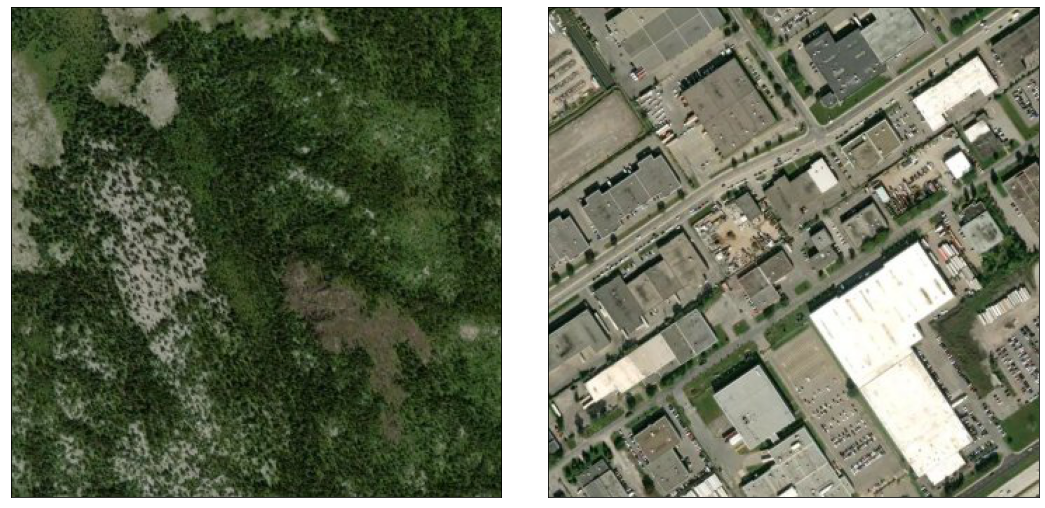

In [34]:
visualize_img(df_train)

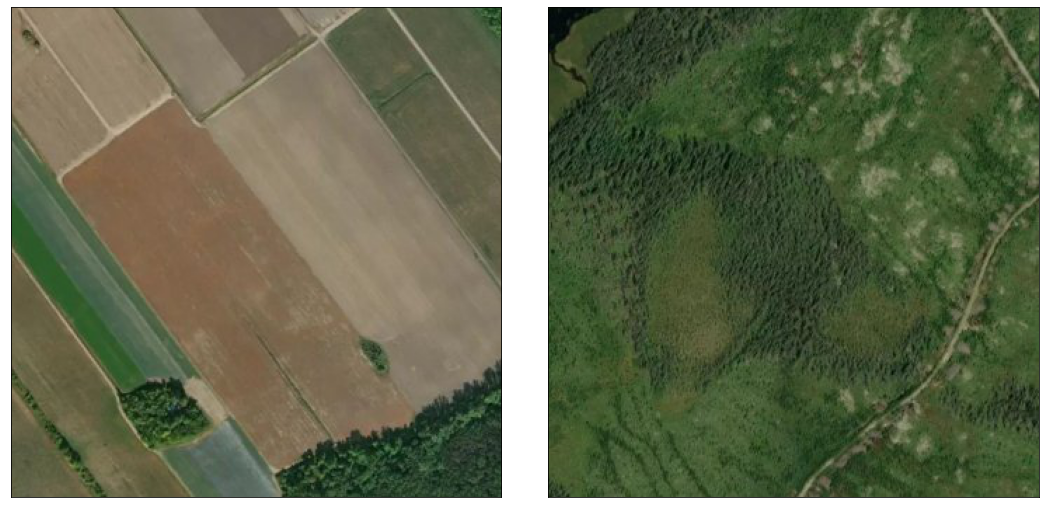

In [36]:
visualize_img(df_test)

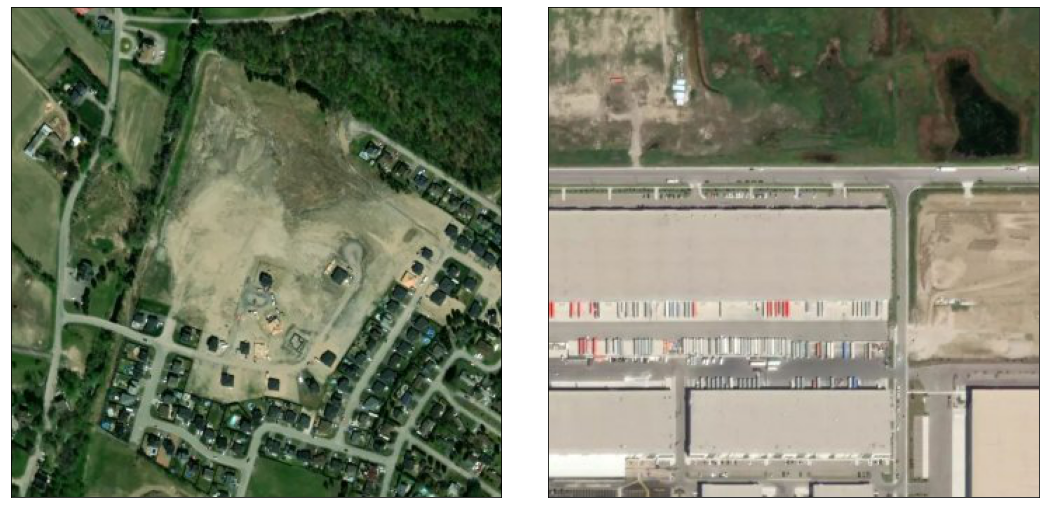

In [38]:
visualize_img(df_valid)

In [7]:
image_shape = (350,350,3)
N_CLASSES = 2
BATCH_SIZE = 256

# load training data & rescalw it using ImageDataGenerator
train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
batch_size = BATCH_SIZE,target_size = (350,350),class_mode = 'categorical')

# load validation data & rescale it using ImageDataGenerator
valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
batch_size = BATCH_SIZE,target_size = (350,350),class_mode = 'categorical')

# load test data & rescale it using ImageDataGenerator
test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
batch_size = BATCH_SIZE,target_size = (350,350),class_mode = 'categorical')

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.


## 3. Building the model

In [10]:
# coefficient that our regularizer will use
weight_decay = 1e-3

# build a sequential CNN model & adding layers to it
# dropout and the regularizer are used in general to prevent overfitting
first_model = Sequential([
    Conv2D(filters = 8 , kernel_size = 2, activation = 'relu', 
    input_shape = image_shape), MaxPooling2D(pool_size = 2),
    
    Conv2D(filters = 16 , kernel_size = 2, activation = 'relu', 
    input_shape = image_shape), MaxPooling2D(pool_size = 2),
    
    Conv2D(filters = 32 , kernel_size = 2, activation = 'relu',
           kernel_regularizer = regularizers.l2(weight_decay)),
    MaxPooling2D(pool_size = 2),
    
    Dropout(0.4),
    Flatten(),
    Dense(300,activation='relu'),
    Dropout(0.5),
    Dense(2,activation='softmax')
])
# summary of our model (layers and number of parameters)
first_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 349, 349, 8)       104       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 174, 174, 8)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 173, 173, 16)      528       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 86, 86, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 85, 85, 32)        2080      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 42, 42, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 42, 42, 32)       

## 4. Training the model

In [68]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# checkpointer to save the model only if it improved
checkpointer = ModelCheckpoint('first_model.hdf5',verbose=1, save_best_only= True)
# early_stopping to stop the training if validation loss didn't decrease for 10 consecutive epochs
early_stopping = EarlyStopping(monitor= 'val_loss', patience= 10)
# Adam, best optimiser for deep learning models to help with the training
optimizer = optimizers.Adam(learning_rate= 0.00001, decay= 1e-5)
# setting our loss function and which metric to evaluate
first_model.compile(loss= 'categorical_crossentropy', optimizer= optimizer,
                    metrics=['AUC','acc'])

# TRAIN
history = first_model.fit(train_generator,
epochs = 5,
verbose = 1,
validation_data = valid_generator,
callbacks = [checkpointer, early_stopping])

Epoch 1/5
119/119 [==============================] - 290s 2s/step - loss: 1.0849 - auc: 0.8611 - acc: 0.7828 - val_loss: 0.8387 - val_auc: 0.9457 - val_acc: 0.8756

Epoch 00001: val_loss improved from inf to 0.83873, saving model to first_model.hdf5
Epoch 2/5
119/119 [==============================] - 242s 2s/step - loss: 0.8207 - auc: 0.9107 - acc: 0.8388 - val_loss: 0.6990 - val_auc: 0.9444 - val_acc: 0.8730

Epoch 00002: val_loss improved from 0.83873 to 0.69905, saving model to first_model.hdf5
Epoch 3/5
119/119 [==============================] - 268s 2s/step - loss: 0.7236 - auc: 0.9169 - acc: 0.8502 - val_loss: 0.6326 - val_auc: 0.9483 - val_acc: 0.8794

Epoch 00003: val_loss improved from 0.69905 to 0.63256, saving model to first_model.hdf5
Epoch 4/5
119/119 [==============================] - 246s 2s/step - loss: 0.6749 - auc: 0.9215 - acc: 0.8546 - val_loss: 0.6006 - val_auc: 0.9489 - val_acc: 0.8803

Epoch 00004: val_loss improved from 0.63256 to 0.60060, saving model to first

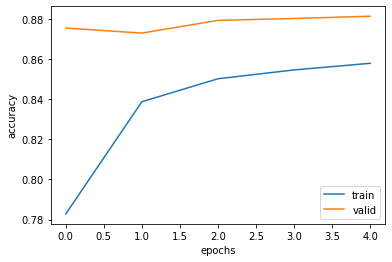

In [71]:
# add history of accuracy and validation accuracy to the plot
plt.plot(history.history['acc'], label = 'train',)
plt.plot(history.history['val_acc'], label = 'valid')

plt.legend(loc = 'lower right')
plt.xlabel('epochs')
plt.ylabel('accuracy')

# show plot
plt.show()

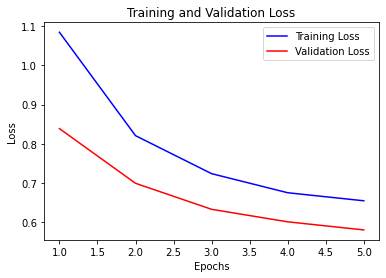

In [72]:
import matplotlib.pyplot as plt

# Get training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting loss vs. epochs
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [69]:
# seeing at predecting new inputs
result = first_model.evaluate(test_generator) 

25/25 [==============================] - 62s 3s/step - loss: 0.5774 - auc: 0.9500 - acc: 0.8811


In [60]:
image_shape = (350,350,3)
N_CLASSES = 2
BATCH_SIZE = 256

# load training data & rescalw it using ImageDataGenerator
train_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
train_generator = train_datagen.flow_from_directory(train_path,
batch_size = BATCH_SIZE,target_size = (350,350),class_mode = 'categorical')

# load validation data & rescale it using ImageDataGenerator
valid_datagen = ImageDataGenerator(dtype='float32', rescale= 1./255.)
valid_generator = valid_datagen.flow_from_directory(valid_path,
batch_size = BATCH_SIZE,target_size = (350,350),class_mode = 'categorical')

# load test data & rescale it using ImageDataGenerator
test_datagen = ImageDataGenerator(dtype='float32', rescale = 1.0/255.0)
test_generator = test_datagen.flow_from_directory(test_path,
batch_size = BATCH_SIZE,target_size = (350,350),class_mode = 'categorical')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import optimizers

# Coefficient that our regularizer will use
weight_decay = 1e-3

# Build a sequential DNN model & adding layers to it
# Dropout and the regularizer are used in general to prevent overfitting
sec_model = Sequential([
    Flatten(input_shape=image_shape),
    Dense(300, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    Dropout(0.4),
    Dense(100, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)),
    Dropout(0.4),
    Dense(2, activation='softmax')
])

# Summary of our model (layers and number of parameters)
sec_model.summary()

# Allow loading truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Define callbacks
checkpointer = ModelCheckpoint('sec_model.hdf5', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Adam optimizer
optimizer = optimizers.Adam(learning_rate=0.00001, decay=1e-5)

# Compile the model
sec_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['AUC', 'accuracy'])

# Train the model
history = sec_model.fit(train_generator,
                          epochs=10,
                          verbose=1,
                          validation_data=valid_generator,
                          callbacks=[checkpointer, early_stopping])

Found 30250 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Found 6300 images belonging to 2 classes.
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 367500)            0         
_________________________________________________________________
dense_24 (Dense)             (None, 300)               110250300 
_________________________________________________________________
dropout_20 (Dropout)         (None, 300)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               30100     
_________________________________________________________________
dropout_21 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 202

In [61]:
# seeing at predecting new inputs
result = sec_model.evaluate(test_generator) 

25/25 [==============================] - 56s 2s/step - loss: 0.7741 - auc: 0.9443 - accuracy: 0.8765


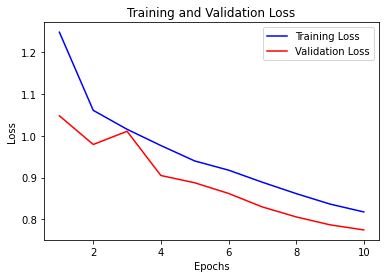

In [62]:
import matplotlib.pyplot as plt

# Get training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting loss vs. epochs
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

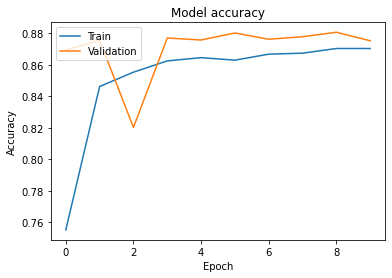

In [63]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [67]:
 import numpy as np
from tensorflow.keras.preprocessing import image

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(350, 350))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0  # Rescale to match the training data
    return img

def predict_class(img_path, model):
    # Preprocess the image
    img = preprocess_image(img_path)
    
    # Predict the class probabilities
    probabilities = model.predict(img)[0]
    
    # Get the predicted class index
    predicted_class_index = np.argmax(probabilities)
    
    return predicted_class_index, probabilities

# Example usage:
img_path = "/kaggle/input/wildfire-prediction-dataset/test/nowildfire/-113.918231,51.154481.jpg"  # Replace with the path to your image
predicted_class_index, probabilities = predict_class(img_path, sec_model)

# Print the results
print("Predicted Class Index:", predicted_class_index)
print("Class Probabilities:", probabilities)

Predicted Class Index: 0
Class Probabilities: [0.9546964  0.04530355]
